In [49]:
using QuantumOptics
using PyPlot
using LaTeXStrings
using Random
using DelimitedFiles
using NPZ, Printf
using LinearAlgebra
using DifferentialEquations
using SpecialFunctions
using SparseArrays
using StatsBase

function mb(op,bases,idx)

    numHilberts = size(bases,1)

    if idx==1
        mbop = op
    else
        mbop = identityoperator(bases[1])
    end

    for i=2:numHilberts

        if i==idx
            mbop = tensor(mbop,op)
        else
            mbop = tensor(mbop,identityoperator(bases[i]))
        end

    end

    return mbop
end

function smoothstep(x)
    if x < 0
        return 0
    elseif x > 1
        return 1
    else
        return 3*x^2 - 2*x^3
    end
end

smoothstep (generic function with 1 method)

In [54]:
function main(N,fockmax; Δc = 2π*20, κ = 2π*0.2, ωz = 2π*0.01, β = 0.1im, g_final=1.5)
   
    # Parameters
    # Δc = 2π*20 # MHz
    # κ = 2π*0.2 # MHz
    # ωz = 2π*0.01 # MHz
    # β = 0.1im
    # g_final = 1.5 # g_c
    
    # Noise update
    dt = 0.1 # us
    
    # Saving
    numTvalsObs = 2000
    
    gc = sqrt( (Δc^2+κ^2)/Δc * ωz / N ) 
    doNoise = κ>0
    
    # Make Hamiltonian. Lets do cavity then spin for the Hilbert space.
    bases = []
    bs = SpinBasis(N//2)
    bc = FockBasis(fockmax)
    bases = [bc,bs]
    Ic = identityoperator(bc)
    Is = identityoperator(bs)  
    
    Ha = ωz * mb(sigmaz(bs)/2,bases,2)
    Hc = Δc * mb(create(bc)*destroy(bc),bases,1)
    H0 = Ha .+ Hc
    Hint = gc * mb(sigmax(bs),bases,2) * mb(create(bc)+destroy(bc),bases,1)
    
    # Feedback Hamiltonian. Kept dimensionless.
    Hfb = mb(create(bc) + destroy(bc),bases,1).data
    # Hfb = mb(sigmax(bs),bases,2).data
    fb = 0 # Mhz, coefficient for Hfb, dynamical variable
    
    # Convert to sparse arrays
    H0 = H0.data
    Hint = Hint.data
    HintIm = -im*Hint
    
    # Make identity operator
    HilbertSize = size(H0)[1]
    Id = zeros(HilbertSize,HilbertSize) + I 
    
    # Collapse operator and non-Hermitian Hamiltonian
    C = sqrt(κ) * mb(destroy(bc),bases,1).data
    CdC = C'*C
    H0eff = H0 .- im*CdC/2
    H0effIm = -im*H0eff
    
    # Displaced collapse operators
    Cp = (C + im*β*I)/sqrt(2)
    Cm = (C - im*β*I)/sqrt(2)
    
    ################################### Ramp function and time span
    
    g(t) = sqrt(g_final)*smoothstep((t-100)/600)
    
    tspan = (0,8000)
    
    ################################### Initial condition
    
    ψ0c = coherentstate(bc,0)
    ψ0a = spindown(bs)
    ψ0  = tensor(ψ0c,ψ0a) 
    
    # Normalize and convert to complex vector.
    ψ0=normalize!(ψ0)
    ψtemplate = copy(ψ0)
    ψ0 = complex.(ψ0.data)
    
    ################################### Observables
    
    sqrtdt = sqrt(dt)
    numSteps = Int(ceil(tspan[2]/dt))
    
    jumpCnts = zeros(numSteps)
    homodyne = 0
    
    numTvalsObs = min(numSteps,numTvalsObs)
    # numTvalsState = min(numSteps,numTvalsState)
    stepsPerSave = Int(floor(numSteps/(numTvalsObs-1.0)))
    # stepsPerStateSave = Int(floor(numSteps/(numTvalsState-1.0)))
    
    # Records denoted with underbar
    t_,E_ = zeros(numTvalsObs), zeros(numTvalsObs)
    x_,y_,z_ = zeros(numTvalsObs), zeros(numTvalsObs), zeros(numTvalsObs)
    xx_, yy_, zz_ = zeros(numTvalsObs), zeros(numTvalsObs), zeros(numTvalsObs)
    a_ = complex.(zeros(numTvalsObs))
    ada_ = zeros(numTvalsObs)
    homodyne_ = zeros(numTvalsObs)
    saveIdx = 1
    
    # Make operators
    a_op, ada_op = mb(destroy(bc),bases,1).data, mb(create(bc)*destroy(bc),bases,1).data
    x_op, y_op, z_op = mb(sigmax(bs),bases,2).data, mb(sigmay(bs),bases,2).data, mb(sigmaz(bs),bases,2).data
    xx_op, yy_op, zz_op = mb(sigmax(bs)*sigmax(bs),bases,2).data, mb(sigmay(bs)*sigmay(bs),bases,2).data, mb(sigmaz(bs)*sigmaz(bs),bases,2).data
    
    
    ################################### Differential equations
    
    function deriv!(du,u,p,t)
        
        mul!(du, H0effIm, u)
        
        mul!(du, HintIm,  u, g(t), 1)
        
        mul!(du, Hfb,  u, -im*fb, 1)
    
    end
    
    function jac!(J,u,p,t)
        J .= H0effIm .+ g(t).*HintIm .- im*fb*Hfb
    end
        
    ################################## ODE Setup 
    
    # Compute sparsity pattern
    jac0 = complex.(0*Id)
    jac!(jac0,randn(HilbertSize),0,1)
    
    # Initialize ODE functions with jacobian built in
    fun = ODEFunction(deriv!; jac=jac!, jac_prototype=jac0)
    
    # Choose your solver
    solver = TsitPap8() #CFRLDDRK64() #TSLDDRK74() #TsitPap()
    abstol = 1e-8 #1e-15 # Default is 1e-6
    reltol = 1e-8 # Default is 1e-3
    # maxiters = 1e6
    
    # Make the problem instance
    prob = ODEProblem(fun,ψ0,tspan)
    
    integrator = init(prob,solver,dt=dt,save_on=false,abstol=abstol,reltol=reltol,save_everystep=false)#,maxiters=maxiters)

    ################################## Integrate
    
    # Reseed the noise instance
    Random.seed!(Int(round(mod(time()*300,1000))))
    
    # Memory for computing jump probs
    ψrand = copy(ψ0)
    jumpProbs = zeros(2)
    
    start = time()
    for step=1:numSteps
    
        # Deterministic step
        step!(integrator,dt,true)
        
        if doNoise
           
            # Renormalize
            normVal = sqrt(abs(dot(integrator.u,integrator.u)))
            integrator.u ./= normVal
            
            # Get jump probability
            exval = integrator.u'*CdC*integrator.u
            pJump = dt*( abs(β)^2 + real(exval) )
            
            # Jump
            if rand()<pJump
                
                # Compute individual jump probs
                ψrand = Cp*integrator.u
                jumpProbs[1] = real(dot(ψrand,ψrand))
                
                ψrand = Cm*integrator.u
                jumpProbs[2] = real(dot(ψrand,ψrand))
                
                # Pick a jump to do
                idx = sample(Weights(jumpProbs))
                
                # Jump
                if idx==1
                    mul!(ψrand, Cp, integrator.u)
                    homodyne += 1
                else
                    mul!(ψrand, Cm, integrator.u)
                    homodyne -= 1
                end
                integrator.u .= ψrand
                
                # Renormalize
                normVal = sqrt(real(dot(integrator.u,integrator.u)))
                integrator.u ./= normVal
                
                jumpCnts[step] = 1
                
            end
        end
        
        ############################################################################
        # Update feedback based on homodyne measurement
        fb = exp(-1/20)*fb # Exponential filter. This is like I gain. 
        fb +=  2*g(integrator.t)*homodyne # Positive feedback
        # fb += -0.2*g(integrator.t)*homodyne # Negative feedback
        ############################################################################
        
        # Saving
        if mod(step-1,stepsPerSave)==0 && saveIdx <= numTvalsObs

            # Renormalize
            normVal = sqrt(real(dot(integrator.u,integrator.u)))
            integrator.u ./= normVal
            
            # Measure and save
            t_[saveIdx] = integrator.t
            x_[saveIdx] = real(dot(integrator.u, x_op, integrator.u))
            y_[saveIdx] = real(dot(integrator.u, y_op, integrator.u))
            z_[saveIdx] = real(dot(integrator.u, z_op, integrator.u))
            xx_[saveIdx] = real(dot(integrator.u, xx_op, integrator.u))
            yy_[saveIdx] = real(dot(integrator.u, yy_op, integrator.u))
            zz_[saveIdx] = real(dot(integrator.u, zz_op, integrator.u))
            a_[saveIdx] = dot(integrator.u, a_op, integrator.u)
            ada_[saveIdx] = real(dot(integrator.u, ada_op, integrator.u))
            E_[saveIdx] = real(dot(integrator.u, H0, integrator.u)) + g(integrator.t)*real(dot(integrator.u, Hint, integrator.u))
            homodyne_[saveIdx] = homodyne
            
            # Reset homodyne signal
            homodyne = 0
            
            saveIdx += 1
            
        end
        
    end
    print(round((time()-start)/60,digits=2));println(" (m)")
    
    expvals = (x_,y_,z_,xx_,yy_,zz_,a_,ada_,E_,homodyne_)
    
    return t_, expvals, g, bases
        
end

main (generic function with 1 method)

In [56]:
# Try out a filter for the homodyne signal
function filter(signal::Vector{Float64}, filter_len::Int)::Vector{Float64}
    N = length(signal)
    filtered = zeros(N)
    for i=2:N
        filtered[i] = filtered[i-1]*exp(-1/filter_len) + signal[i]/filter_len
        # filtered[i] = filtered[i-1]*0.9 + 0.2*homodyne_[i]
    end
    return filtered
        
end

function two_point_correlator(signal::Vector{Float64}, window::Int;prefilter::Union{Nothing, Integer}=nothing, delay_start::Union{Nothing, Integer}=nothing)::Vector{Float64}
    if delay_start != nothing
        signal = signal[delay_start:length(signal)]
    end
    N = length(signal)
    if prefilter != nothing
        signal = filter(signal, prefilter)
        N = N-1
    end
    rslt = zeros(window)
    for i = 1:window
        rslt[i] = sum(signal[1:N-i] .* signal[i+1:N])/(N-window)
    end
    return rslt
end

two_point_correlator (generic function with 4 methods)

In [60]:
N = 8
fockmax = 3

t_, expvals, g, bases = main(N,fockmax)
x_,y_,z_,xx_,yy_,zz_,a_,ada_,E_,homodyne_ = expvals
numTvalsObs = length(homodyne_)

0.17 (m)


2000

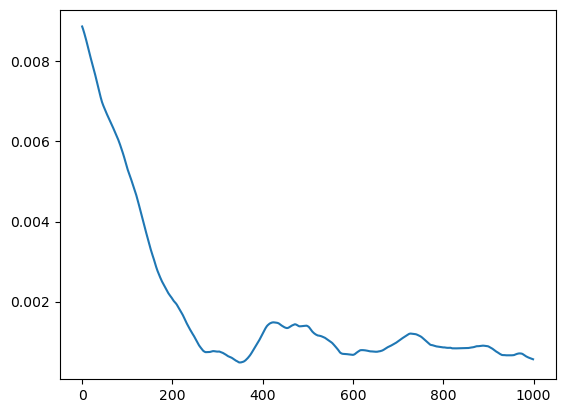

In [61]:
plot(two_point_correlator(homodyne_, 1000, prefilter=100, delay_start=700))
PyPlot.display_figs()

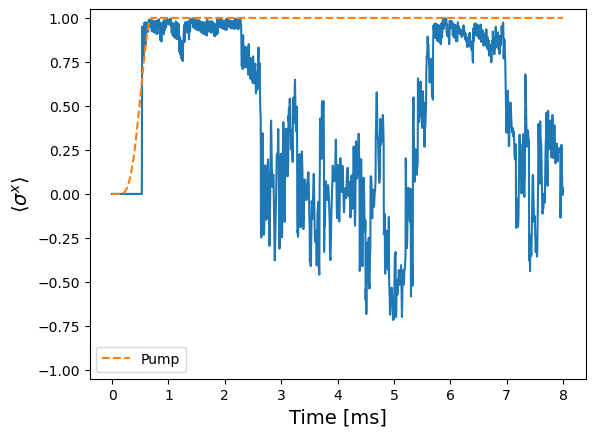

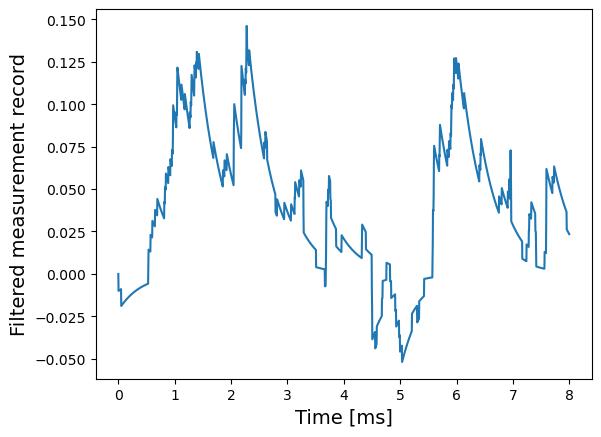

In [62]:
# plot(t_,g.(t_).^2,"--")
# PyPlot.display_figs()

# plot(t_,z_ ./N)
# PyPlot.display_figs()

plot(t_*1e-3,x_ ./N)
plot(t_*1e-3,g.(t_).^2/(1.5),"--",label="Pump")
xlabel("Time [ms]",fontsize=14)
ylabel(L"$\langle \sigma^x \rangle$",fontsize=14)
legend()
ylim(-1.05,1.05)
PyPlot.display_figs()

# plot(t_,ada_)
# PyPlot.display_figs()

filtered = filter(homodyne_, 100)

plot(t_*1e-3,filtered)
xlabel("Time [ms]",fontsize=14)
ylabel("Filtered measurement record",fontsize=14)
PyPlot.display_figs()

# plot(t_,cumsum(homodyne_))
# PyPlot.display_figs()
